In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2022-06-16 23:18:09--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0s      

2022-06-16 23:18:10 (17.3 MB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh == http* ]]
+ PYBIND11_

In [ ]:
from fenics import *

In [ ]:
#Mesh
n = 10
mesh = UnitSquareMesh(n, n, 'crossed')

V = VectorElement('P', mesh.ufl_cell(), 2) #as polynonial as order 1
# define finite element on each cell as P1

Q = FiniteElement('P', mesh.ufl_cell(), 1)

#cartesian product
X = FunctionSpace(mesh, MixedElement([V, Q]))

# Boundary conditions
g_D= Expression(('near(x[1], 1) ? 1. : 0. ', '0.'), degree=4)

def boundary(x, on_boundary):
    return on_boundary


# X.sub(0) = V, but on the entire mesh
bc_u = DirichletBC(X.sub(0), g_D, boundary)

def origin(x, on_boundary):
    return near(x[0], 0) and near(x[1], 0) # first x is equal zero, second y is zero

bc_p = DirichletBC(X.sub(1), Constant(0.), origin, 'pointwise') # one node pointwise

#Variational formulation

u, p = TrialFunctions(X)
v, q = TestFunctions(X)

f = Constant((0., 0.))
a = inner(grad(u), grad(v)) * dx - div(v) * p * dx + q * div(u) * dx
L = dot(f, v) * dx

#Solve the problem

x= Function(X)
solve(a==L, x, [bc_u, bc_p])

In [ ]:
u, p = x.split() #Extract

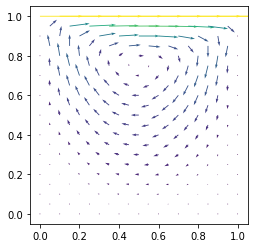

In [ ]:
plot(u) #sort of vortex

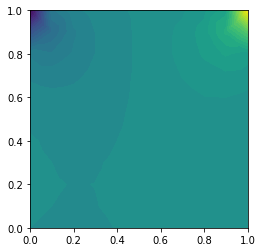

In [ ]:
plot(p) # for P this what er expected, when you have the curvature of the flow
# you have to expect that center of high pressure and center of low pressure
# depending on where the loads curving towards

In [ ]:
# Rebuilt just B^T and check its rank
print('Number of velocity dofs =' , X.sub(0).dim())
print('Number of pressure dofs =' , X.sub(1).dim())

u, p = TrialFunctions(X)
bT = -div(v) * p * dx
BT = assemble(bT)

import numpy as np
BTnp = BT.array()
print('rank of B^T = ', np.linalg.matrix_rank(BTnp))
# For P1, Rank of BT & pressure dof not coherent
# and so the kernel of BT is not just a zero vector not trivial, we'll have strange oscillation

Number of velocity dofs = 1682
Number of pressure dofs = 221
rank of B^T =  221


In [ ]:
def solve_stokes(n, degreeU, degreeP, gD, f, press):
  mesh = UnitSquareMesh(n, n, 'crossed')

  V = VectorElement('P', mesh.ufl_cell(), degreeU)
  if degreeP==0:
    Q = FiniteElement('DP', mesh.ufl_cell(), 0) #P0 element
  else:
    Q = FiniteElement('P', mesh.ufl_cell(), degreeP)

  X = FunctionSpace(mesh, MixedElement([V, Q]))

  #Define Boundary Conditions
  #Velocity
  def boundary(x, on_boundary):
    return on_boundary

  # X.sub(0) = V, but on the entire mesh
  bc_u = DirichletBC(X.sub(0), gD, boundary)

  # Pressure
  def origin(x, on_boundary):
    return near(x[0], 0) and near(x[1], 0)

  bc_p = DirichletBC(X.sub(1), press, origin, 'pointwise')

  bc = [bc_u, bc_p]

  #Variational formulation
  u, p = TrialFunctions(X)
  v, q = TestFunctions(X)

  a = inner(grad(u), grad(v)) * dx
  bt = -p * div(v) * dx
  b = -div(u) * q * dx

  L = dot(f,v) * dx

  m = a + bt + b

  x = Function(X)
  solve(m==L, x, bc)

  u, p = x.split()

  return u, p

In [ ]:
u_exact = Expression(('-cos(x[0]) * sin(x[1])','sin(x[0]) * cos(x[1])'), degree=4)
p_exact = Expression('-0.25 * (cos(2*x[0]) + cos(2*x[1]))',degree=4)
f = Expression(('-2 * cos(x[0]) * sin(x[1]) + 0.5 * sin(2 * x[0])','2 * sin(x[0]) * cos(x[1]) + 0.5 * sin(2 * x[1])'), degree=4)
gD = u_exact

uh, ph = solve_stokes(20, 2, 1, gD, f, p_exact) #P2/P1 elements

In [ ]:
errornorm(p_exact, ph, 'L2')

0.0002549282746476167

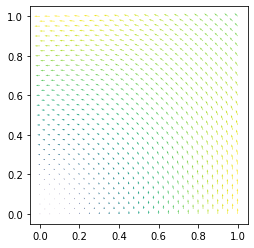

In [ ]:
plot(uh)

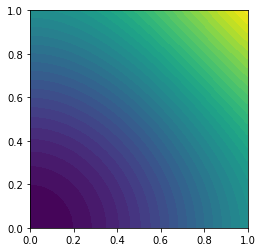

In [ ]:
plot(ph)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_vec = np.array((10, 20, 40))
for ii in range(n_vec.shape[0]):
  n = n_vec[ii]
  uh, ph = solve_stokes(n, 2, 1, gD, f, p_exact)

  err_u_L2 = errornorm(u_exact, uh, 'L2')
  err_u_H1 = errornorm(u_exact, uh, 'H1')
  err_p_L2 = errornorm(p_exact, ph, 'L2')
  err_p_H1 = errornorm(p_exact, ph, 'H1')
  print('n = ', n_vec[ii])
  print('L2 error, velocity = ', err_u_L2)
  print('H1 error, velocity = ', err_u_H1)
  print('L2 error, pressure = ', err_p_L2)
  print('H1 error, pressure = ', err_p_H1)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
n =  10
L2 error, velocity =  4.590132501673023e-06
H1 error, velocity =  0.0003991448013216657
L2 error, pressure =  0.0010138201027085065
H1 error, pressure =  0.01874710817517643
n =  20
L2 error, velocity =  5.722428190434477e-07
H1 error, velocity =  9.971852639604871e-05
L2 error, pressure =  0.0002549282746476167
H1 error, pressure =  0.009351404583384347
n =  40
L2 error, velocity =  7.147793682127156e-08
H1 error, velocity =  2.492476132809779e-05
L2 error, pressure =  6.383797934759242e-05
H1 error, pressure =  0.004672787